# Spotify Wrapped (Kathleen's Version) 🎧

On average, [a Spotify user listens to 148 minutes of music daily or 54,750 minutes yearly](https://siteefy.com/spotify-statistics/). According to my 2020 Spotify Wrapped, as seen below, I listened to 254,361 minutes of music in (almost) a whole year, which is **4.6x** more than the average user. <img src="wrapped2020.JPG" alt="image" width="200"/>

Sadly, Spotify Wrapped only collects listening data from January 1 to October 31 of each year, so we miss out on ~17% of quality material (think of all the wintertime music that gets excluded!). Lucky for me, Spotify allows users to request and download their personal data, which includes streaming history from the past year from the date of request. 

In honor of Taylor Swift's re-recorded versions of her past albums, I decided to create my own version of my Spotify Wrapped with listening data from November 18, 2020 to November 18, 2021. Maybe I'll re-request my data on December 31 and rerun this code with new data to get a complete year of listening history 😄 

📚 First, import `tidyverse`, `lubridate`, `jsonlite`, `scales`, and `ggrepel` using the `library` function.

In [20]:
library(tidyverse)
library(lubridate)
library(jsonlite)
library(scales)
library(ggrepel)

Due to my extensive consumption of Spotify, it took 3 days to receive my data files. Sure enough, I had **8** jam-packed files of streaming history.

In order to utilize them all to analyze the data comprehensively, I merged the 8 json files into 1 big file by doing the following: 
1. created a vector of the files called `stream`
2. applied the `do.call("rbind", )` function over `stream` and stringified the data 
3. wrote the merged json file called `streamHistory`

In [21]:
stream = c("StreamingHistory0.json","StreamingHistory1.json", "StreamingHistory2.json", "StreamingHistory3.json",
           "StreamingHistory4.json", "StreamingHistory5.json", "StreamingHistory6.json", "StreamingHistory7.json")
streamHistory = do.call("rbind", lapply(stream, function(f) fromJSON(f)))
write(toJSON(streamHistory))

Spotify's streaming history file gives us 4 variables to start with:
1. `endTime` = Date and time of when the stream ended in UTC format (Coordinated Universal Time zone)
2. `artistName` = Name of "creator" for each stream (e.g. the artist name if a music track)
3. `trackName` = Name of items listened to or watched (e.g. title of music track or name of video)
4. `msPlayed` = msPlayed”- Stands for how many mili-seconds the track was listened to

In [3]:
streamHistory %>% head(n=1)

,endTime,artistName,trackName,msPlayed
,<chr>,<chr>,<chr>,<int>
1,2020-11-17 20:33,U.S.A. For Africa,We Are The World,289950


I created a tibble called `spotify` with additional variables&mdash;`date`, `seconds`, `minutes`, `hours`, `month`&mdash;derived from the original variables provided.

In [4]:
spotify = streamHistory %>% 
  as_tibble() %>% 
  mutate_at("endTime", ymd_hm) %>% 
  mutate(endTime = endTime - hours(6)) %>% 
  mutate(date = floor_date(endTime, "day") %>% 
  as_date, seconds = msPlayed / 1000, minutes = seconds / 60, hours = minutes / 60) %>%
  mutate(month = format(date, "%B")) 

spotify %>% head(n=1)

endTime,artistName,trackName,msPlayed,date,seconds,minutes,hours,month
<dttm>,<chr>,<chr>,<int>,<date>,<dbl>,<dbl>,<dbl>,<chr>
2020-11-17 14:33:00,U.S.A. For Africa,We Are The World,289950,2020-11-17,289.95,4.8325,0.08054167,November


### What song am I loving this month?

The cool thing about seeing my most played track each month is that I can almost remember all the reasons why that song was streamed so often. Some correlate with the release of the song at the beginning of the month (see January, August, September, December), while some correlate with events (e.g. The Weeknd performed at the Super Bowl, so I binged two of the songs he performed in February and March).

In [53]:
order = c('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')

months = spotify %>% filter(date >= "2021-01-01") %>%
    group_by(trackName, month) %>%
    summarize(totalHour = sum(hours), .groups = 'drop') %>%
    group_by(month) %>%
    slice_max(totalHour, n = 1) %>%
    mutate(month = factor(month, levels = order))

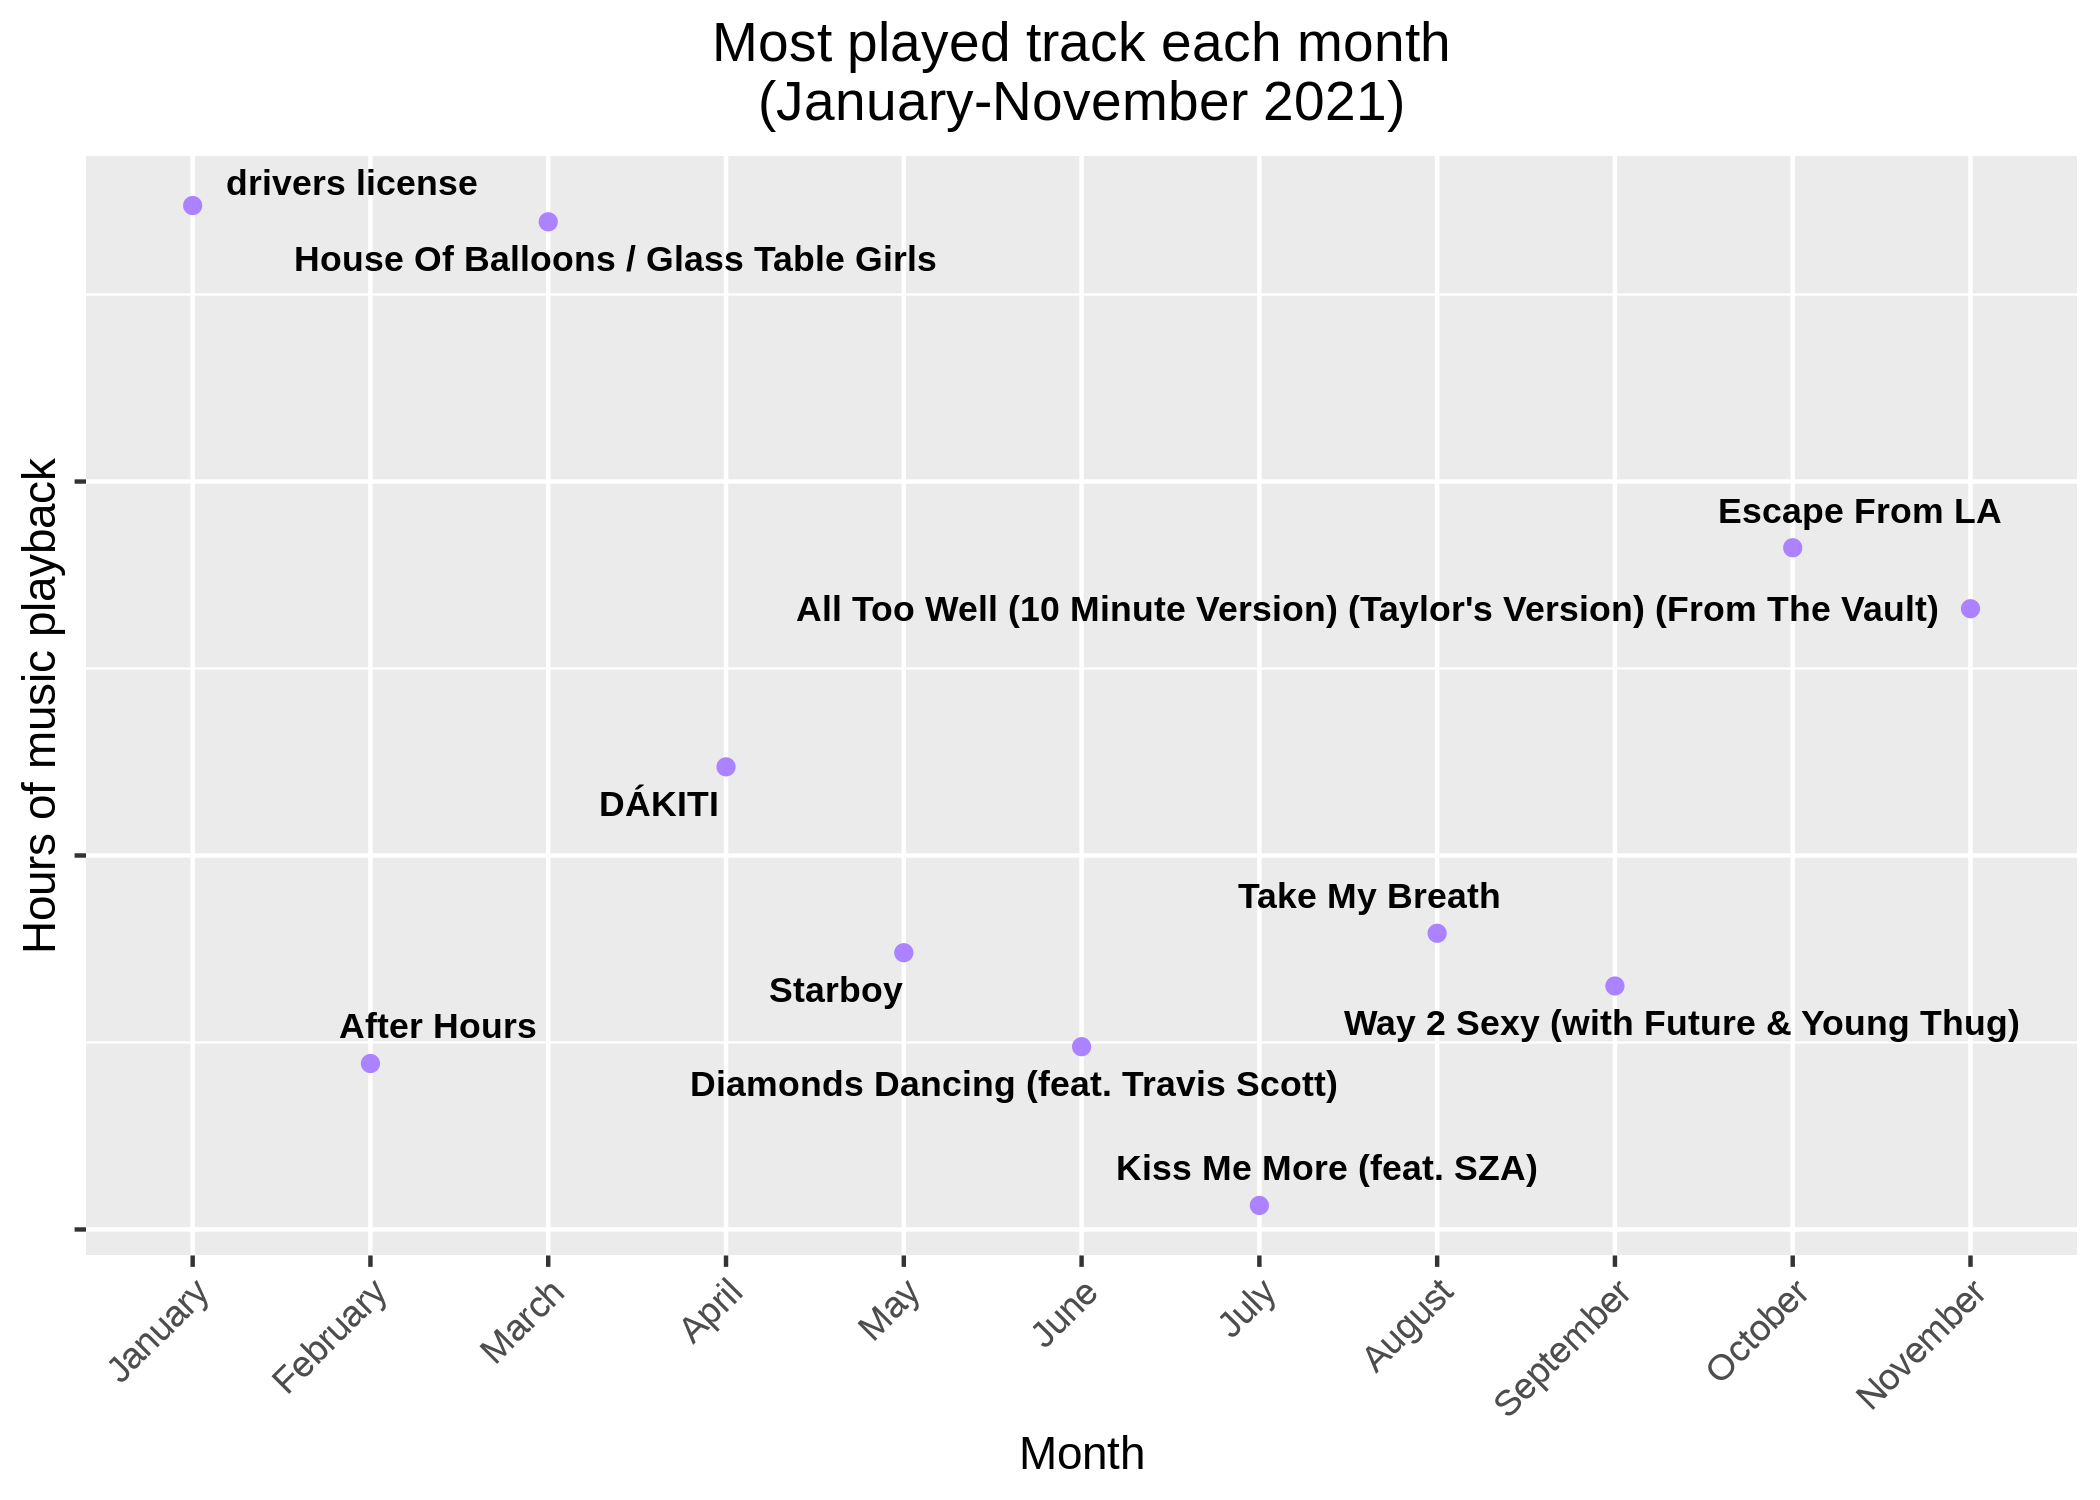

In [98]:
options(repr.plot.res = 300, repr.plot.height = 5, repr.plot.width = 7)

p = ggplot(months, aes(x = month, y = totalHour)) 

p = p + geom_point(color = "mediumpurple1")

p = p + geom_text_repel(data = months, size= 3, aes(label= trackName), 
                        fontface = 'bold', force= 1, point.padding = unit(4, 'lines'))

p = p + labs(x= "Month", y= "Hours of music playback", 
             title = "Most played track each month\n(January-November 2021)")

p = p + theme_grey()

p = p + theme(axis.text.x = element_text(angle = 45,  hjust= 1), 
              axis.text.y=element_blank(),
              plot.title = element_text(hjust = 0.5))

p

### Week by week, month by month

According to the line graph illustrating hours of playback activity between January-November 2021, playback activity peaked around February, almost hitting 100 hours, and dipped at the end of March to 40 hours. There are many rapid changes from week to week as seen from the numerous peaks and troughs.

In [99]:
streamingHours = spotify %>% filter(date >= "2021-01-03") %>%
    group_by(date) %>% 
    group_by(date = floor_date(date, "week")) %>%
    summarize(hours = sum(minutes) / 60, minutes= sum(seconds)/60) %>% 
    arrange(date)

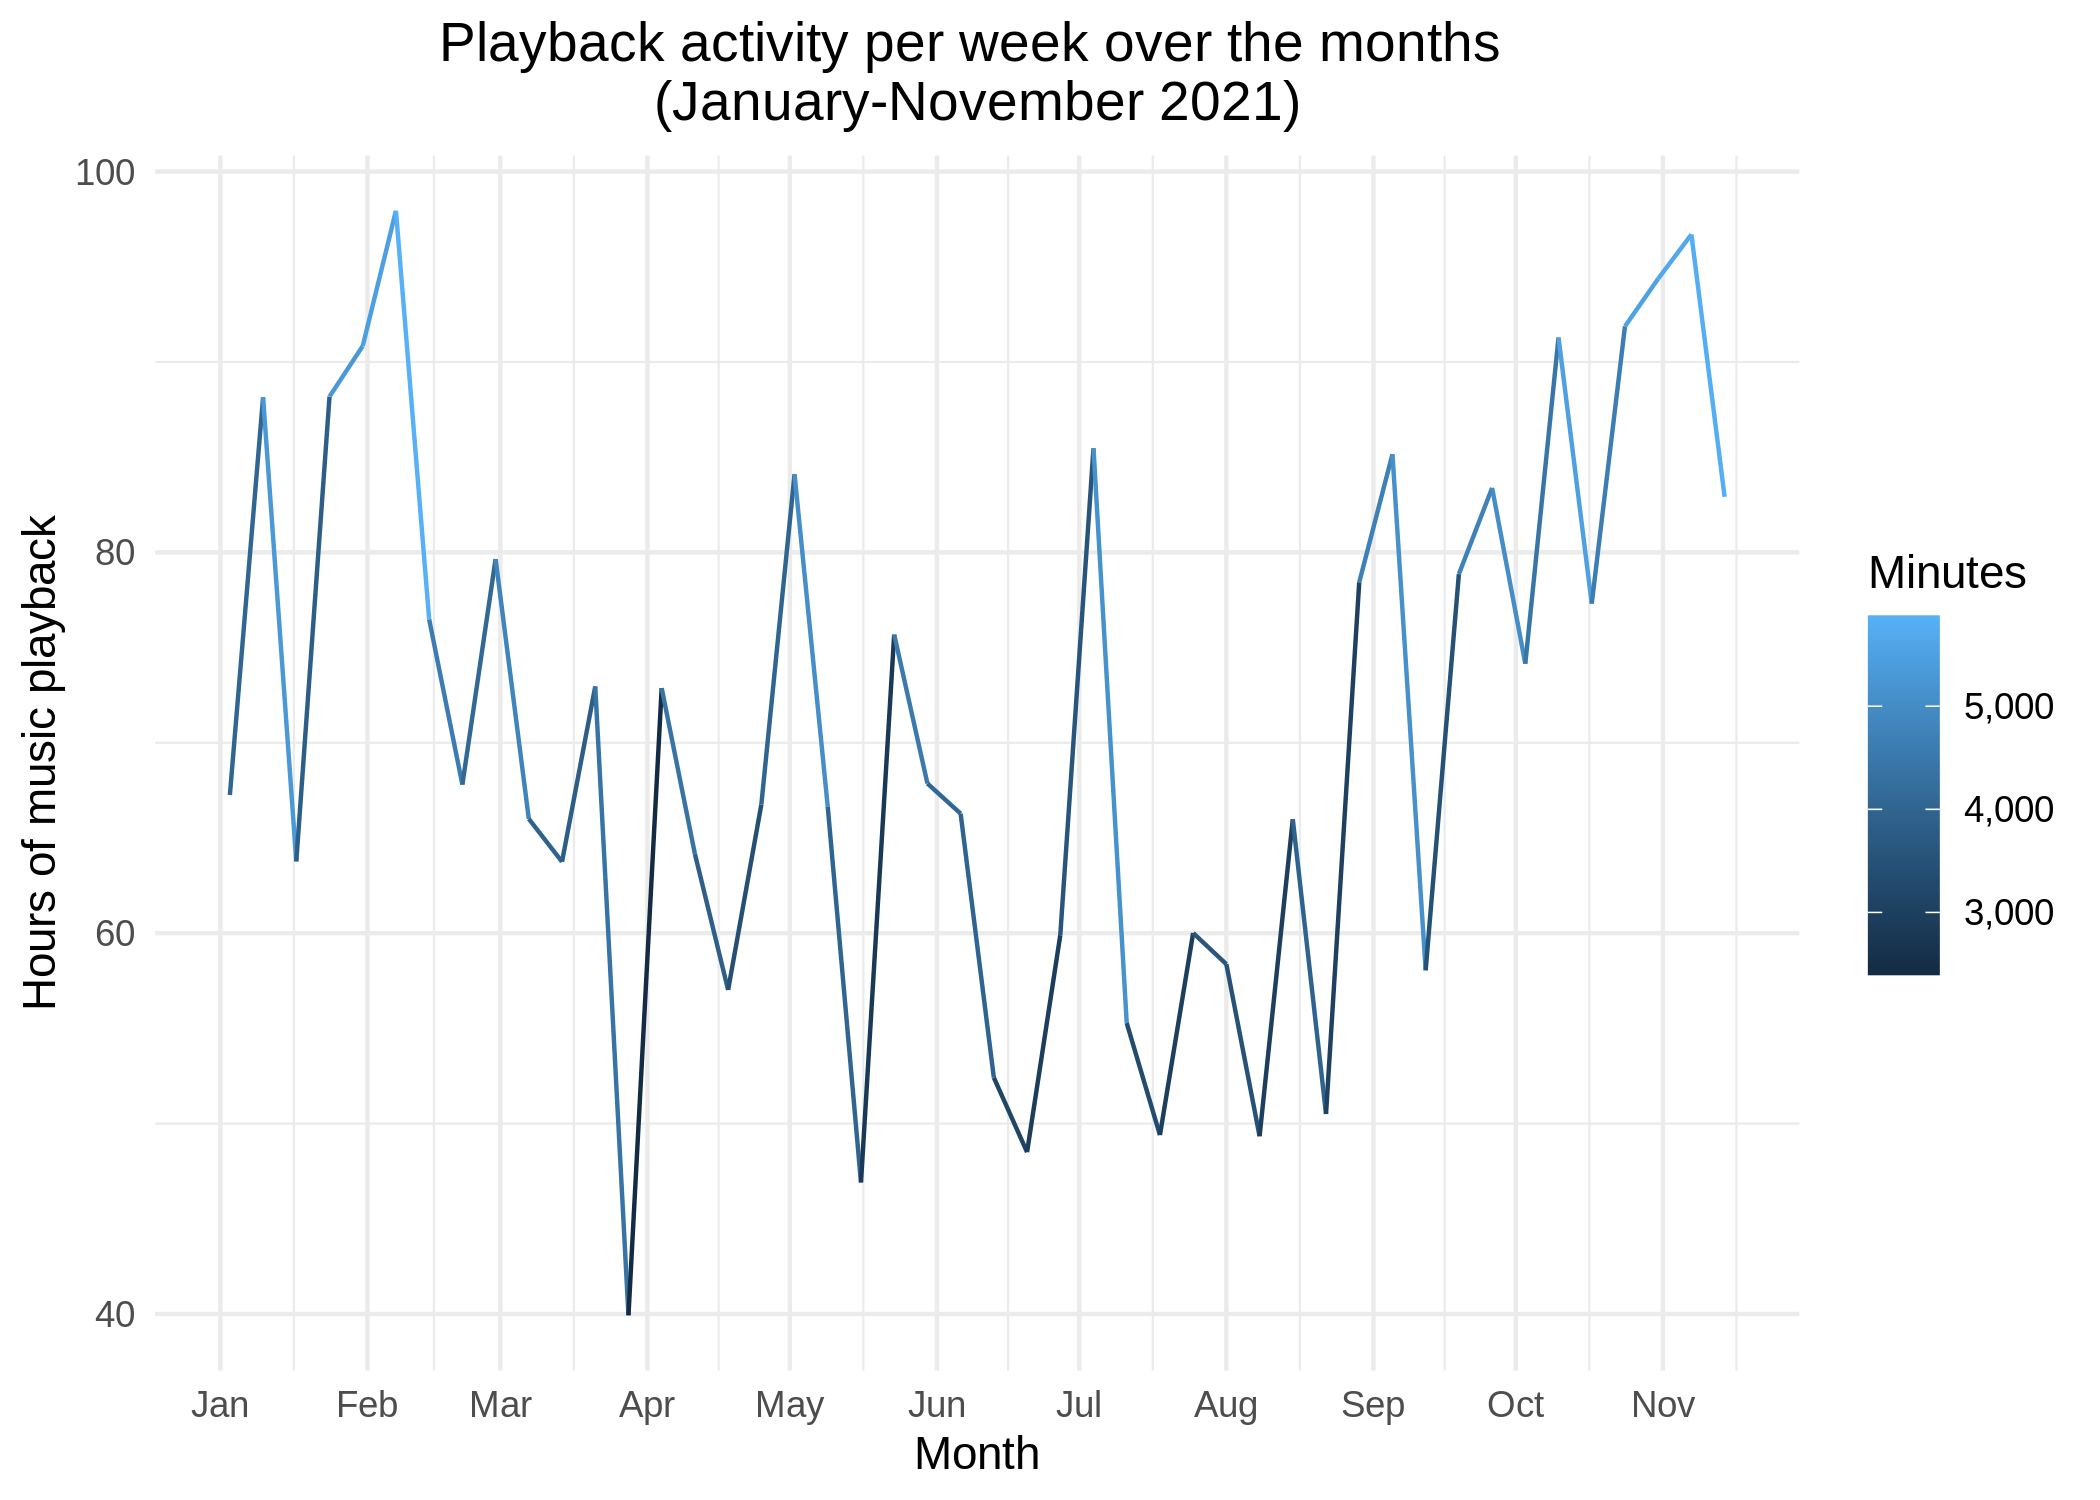

In [100]:
p = ggplot(streamingHours, aes(x = date, y = hours, color= minutes)) 

p = p + geom_line()

p = p + labs(x= "Month", y= "Hours of music playback", 
             title = "Playback activity per week over the months \n(January-November 2021)", color= "Minutes")

p = p + scale_color_continuous(labels = comma)

p = p + scale_x_date(date_labels = "%b", date_breaks = "1 month")

p = p + theme_minimal()

p = p + theme(plot.title = element_text(hjust = 0.5))

p

### After Hours

I'm guilty of listening to music at any and every point of the day, even when I'm sleeping (my freshman year suitemates can vouch for this). Looking at the heatmap I created using the `geom_tile` function to plot time of day and day of the week, we see that most of my time spent streaming music is between 2-6am when I sleep, which makes sense with my sleeping-with-music-blasting habit. I listen to music most often on Monday-Thursday, especially during those early morning hours, because I stay up late doing homework on days I have class.

In [101]:
hoursDay = spotify %>% 
  group_by(date, hour = hour(endTime), weekday = wday(date, label = TRUE))%>% 
  summarize(minutesListened = sum(minutes))

hoursDay_df = hoursDay %>% 
  group_by(weekday, hour) %>% 
  summarize(minutes = sum(minutesListened)) 

`summarise()` has grouped output by 'date', 'hour'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'weekday'. You can override using the `.groups` argument.



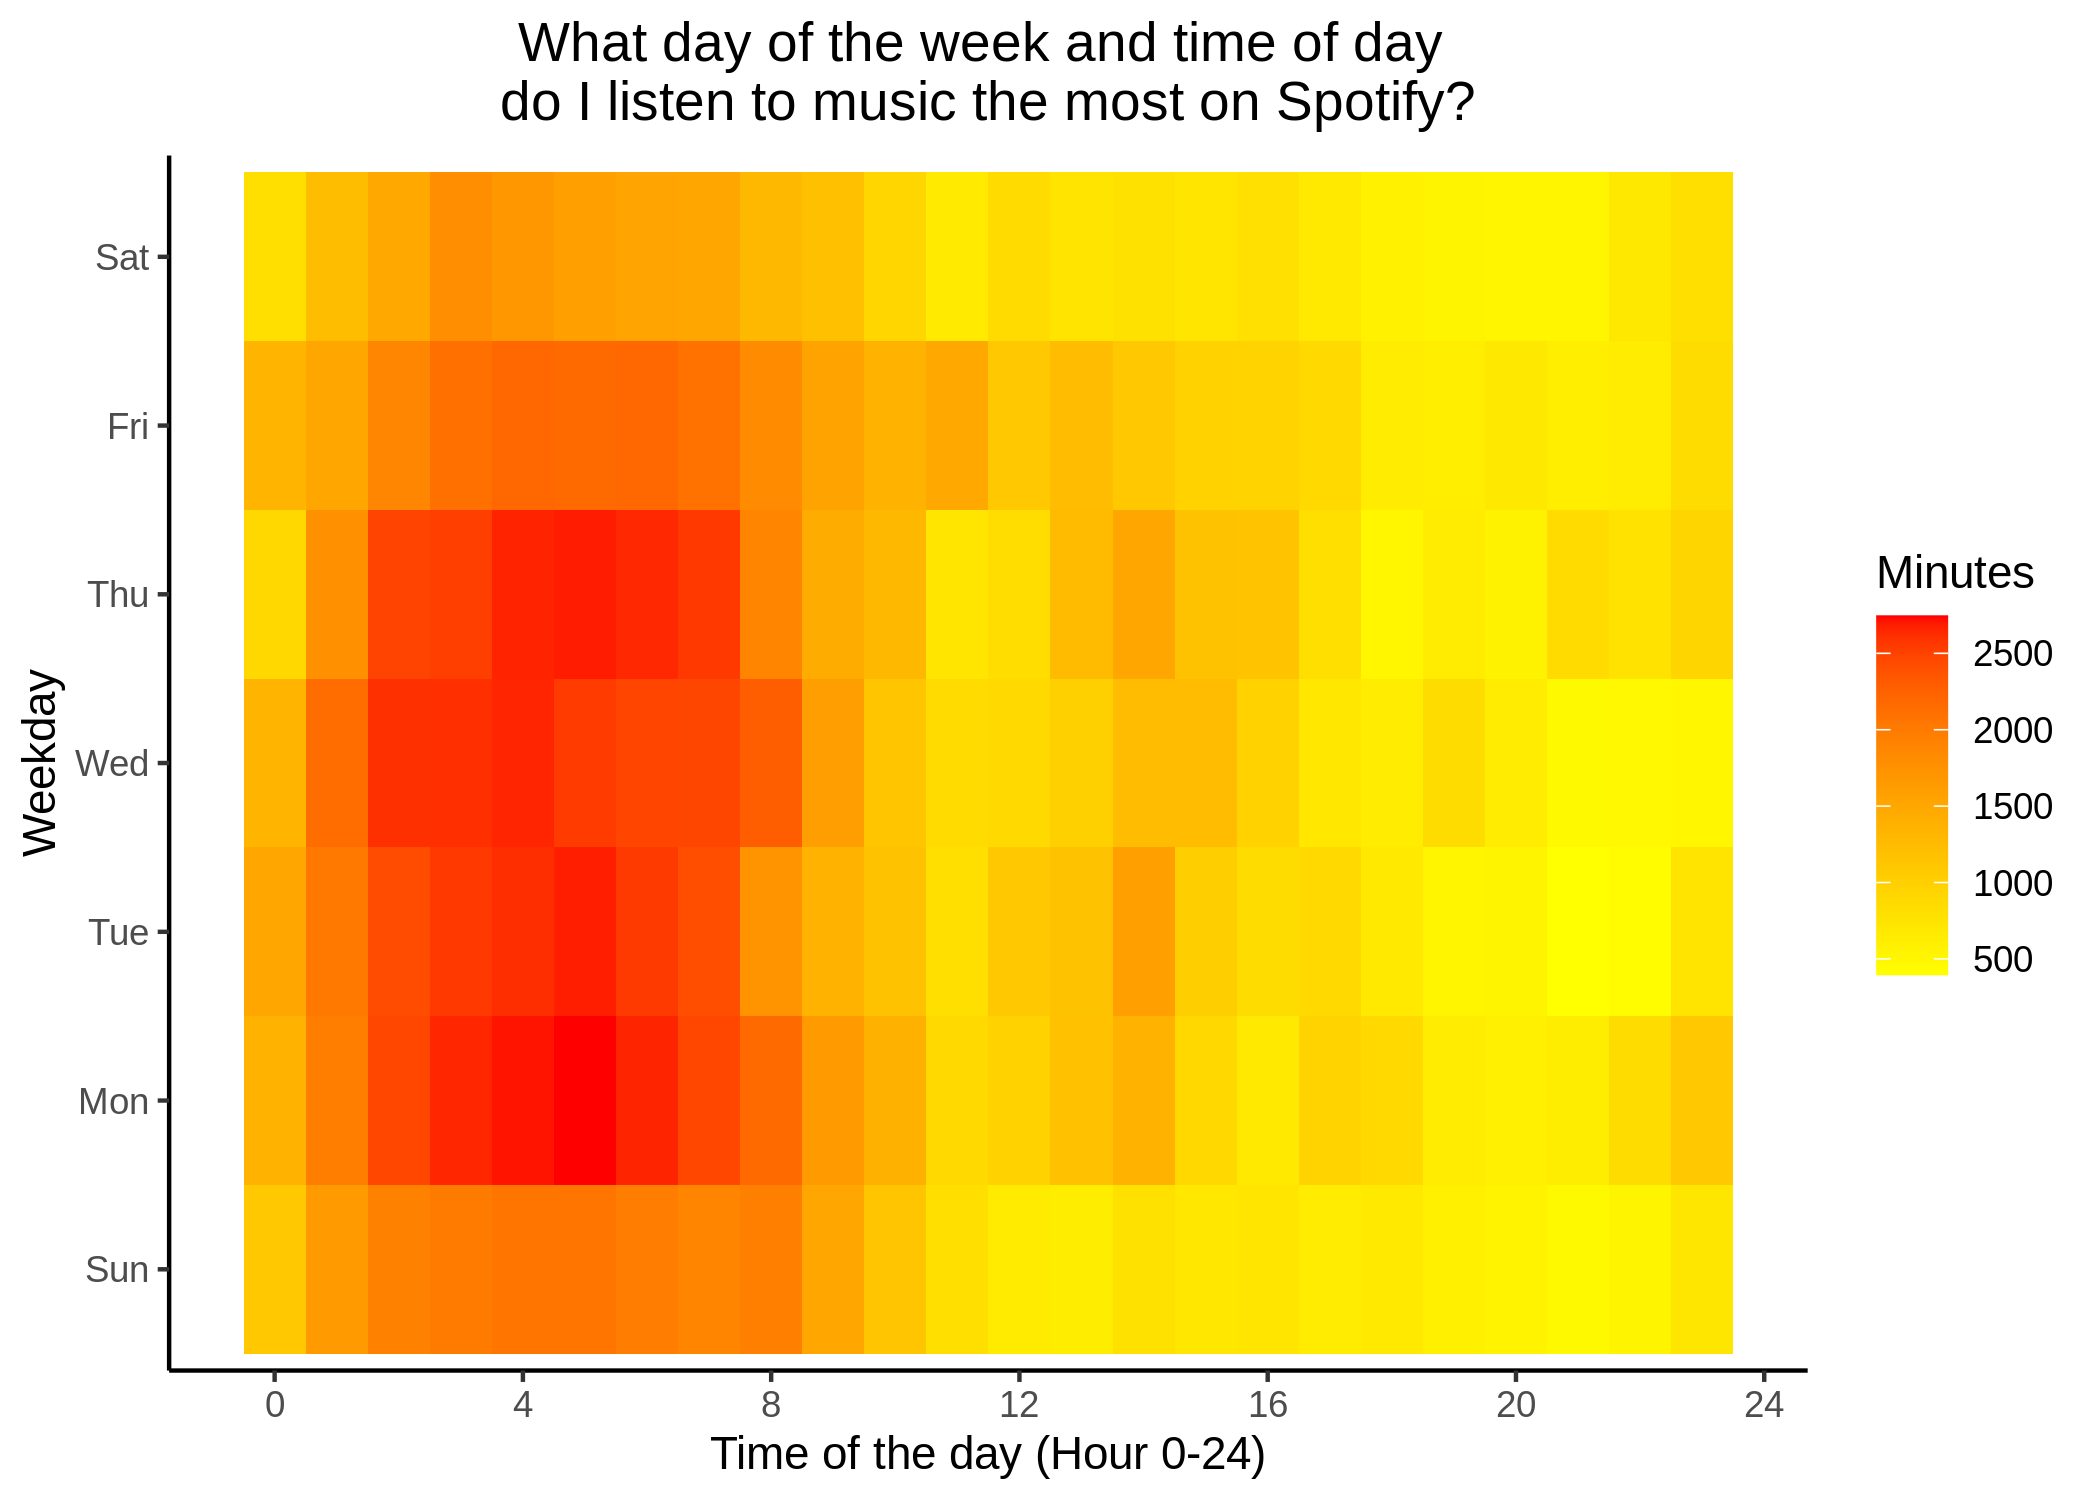

In [102]:
p = ggplot(hoursDay_df, aes(x = hour, weekday, fill= minutes))

p = p + geom_tile()

p = p + scale_fill_gradient(low = "yellow", high = "red")

p = p + labs(x= "Time of the day (Hour 0-24)", y= "Weekday", 
             title= "What day of the week and time of day \ndo I listen to music the most on Spotify?", fill = "Minutes")

p = p + scale_x_continuous(breaks = c(0,4,8,12,16,20,24))

p = p + theme_classic()

p = p + theme(plot.title = element_text(hjust = 0.5))

p

### My Most Streamed Artists

I used the `slice_max` function to gather the 10 artists I stream most often.

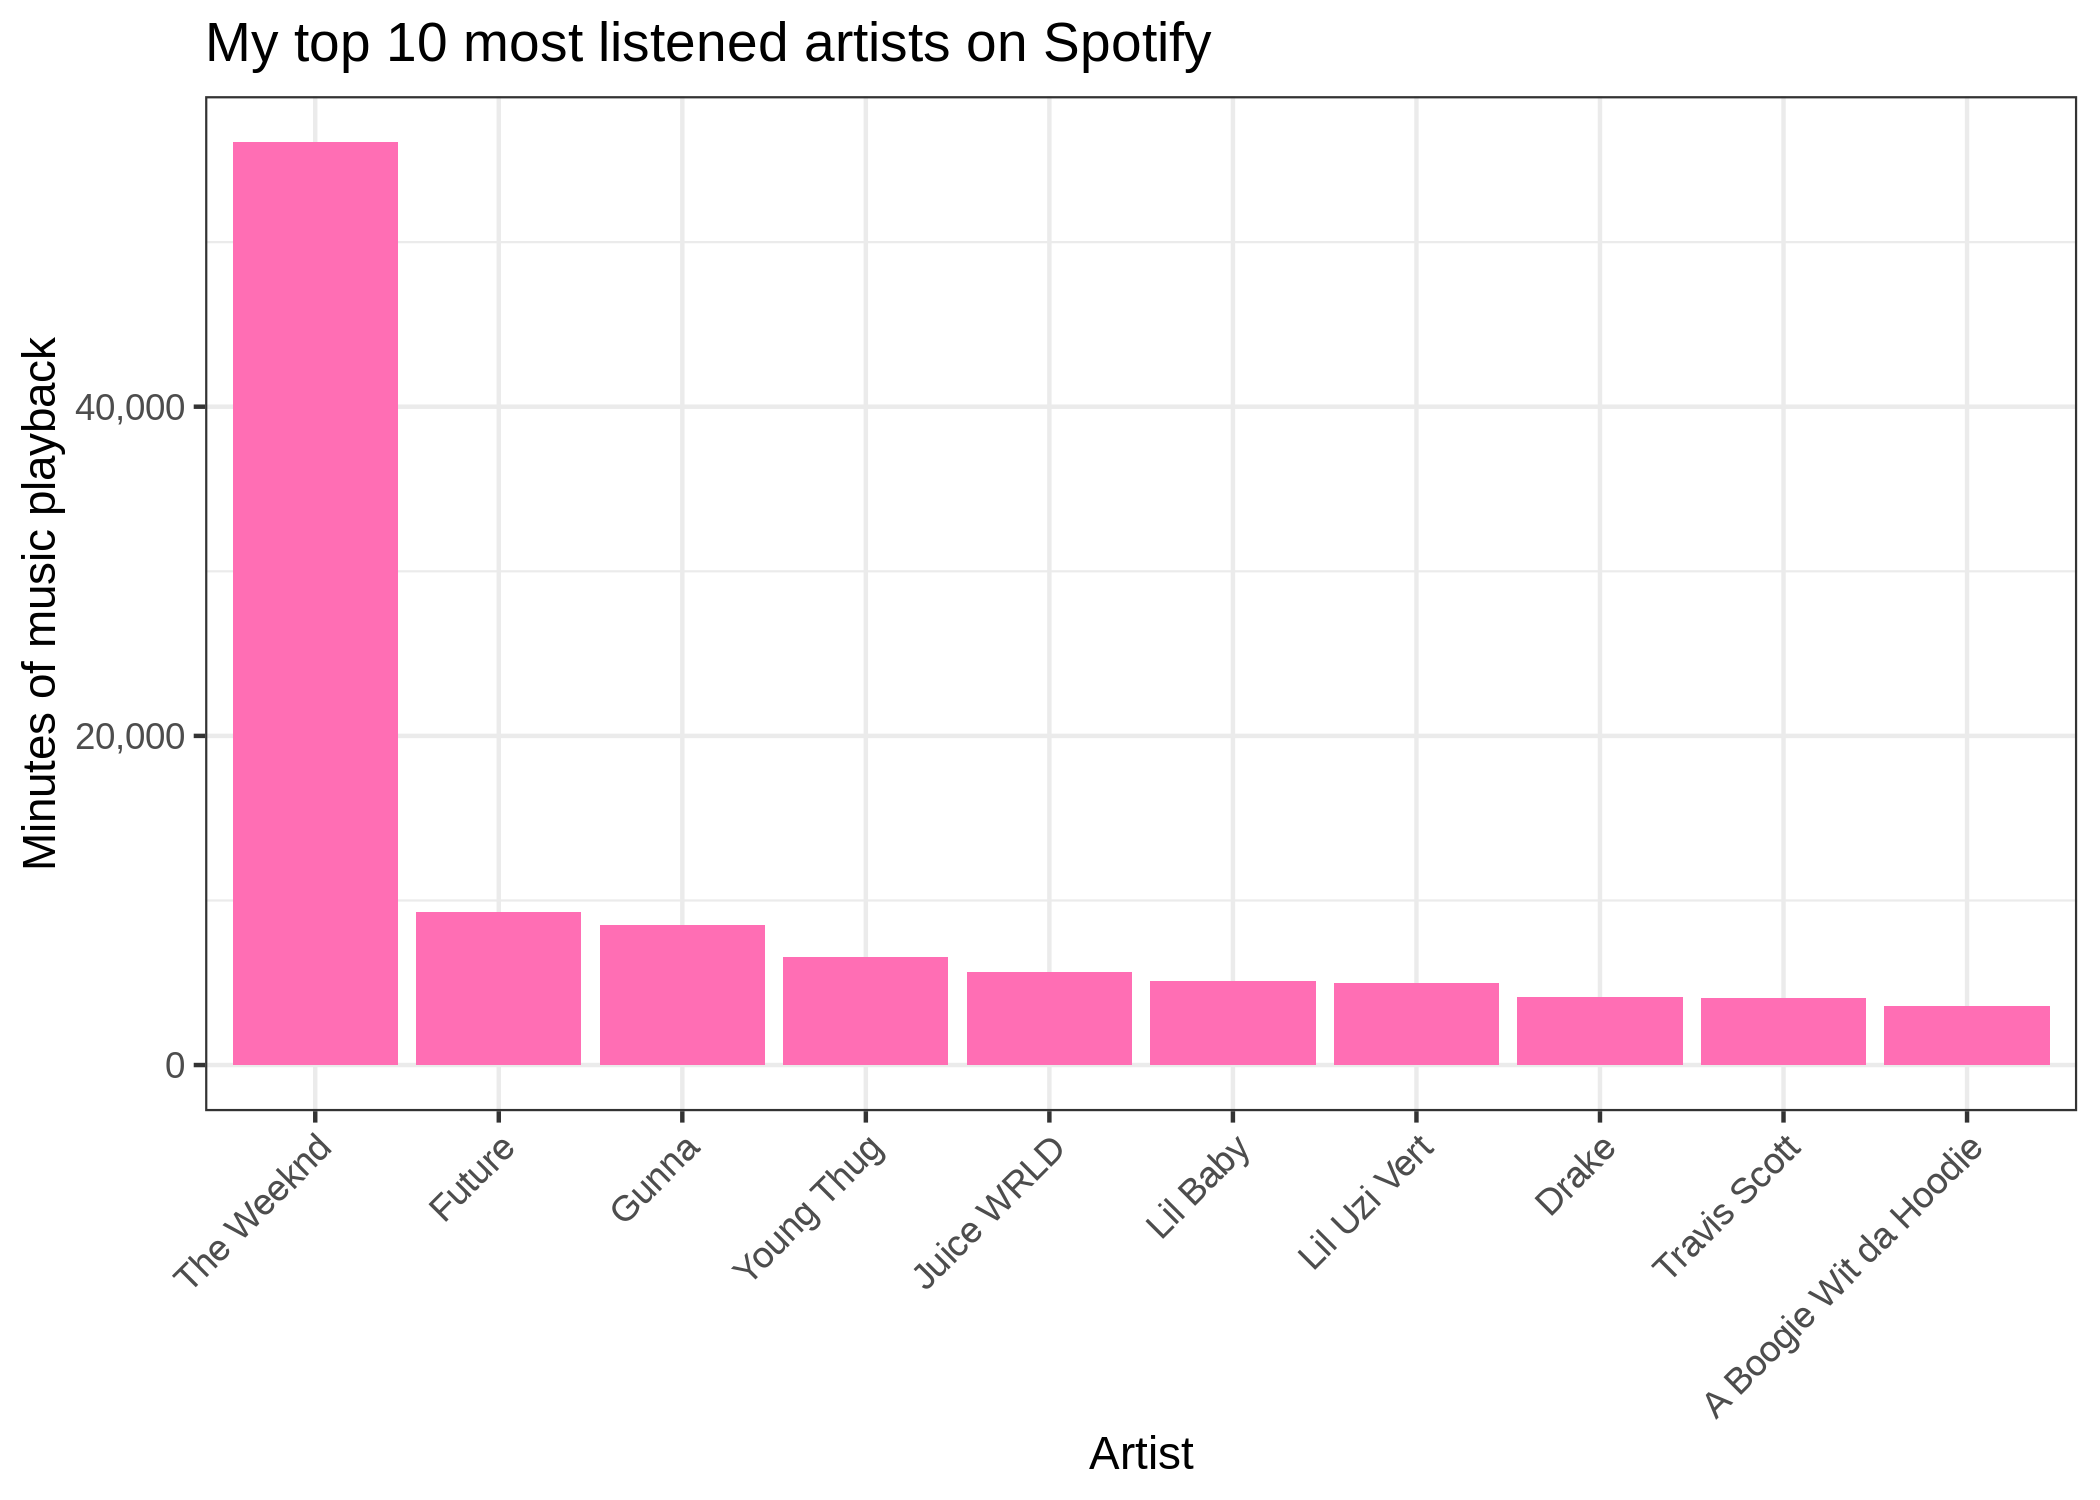

In [103]:
artist = spotify %>% 
    group_by(artistName) %>% 
    summarize(minutesListened = sum(minutes), hoursListened = sum(hours)) %>% 
    slice_max(order_by = minutesListened, n=10)

p = ggplot(artist, aes(x = reorder(artistName, desc(minutesListened)), y = minutesListened))  

p = p + geom_col(fill= "hotpink1")

p = p + labs(x= "Artist", y= "Minutes of music playback", 
             title = "My top 10 most listened artists on Spotify")

p = p + scale_y_continuous(labels = comma)

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(angle = 45,  hjust= 1))

p

### The Weeknd's Biggest Fan?

From the last graph, we see that the Weeknd wins the spot for my most listened artist *by far*. After summing up the minutes spent listening to the Weeknd from the past year, it's evident that I listen to the Weeknd (56,066 minutes) more than the average user listens to music in one year (54,750 mintes). 

In [104]:
spotify %>% filter(artistName == "The Weeknd") %>% summarize(totalAbel = sum(minutes))

totalAbel
<dbl>
56066


Now, using `slice_max` and `forcats` functions, I created a bar chart with `geom_col()` to see out which songs I listen to most by my favorite artist.

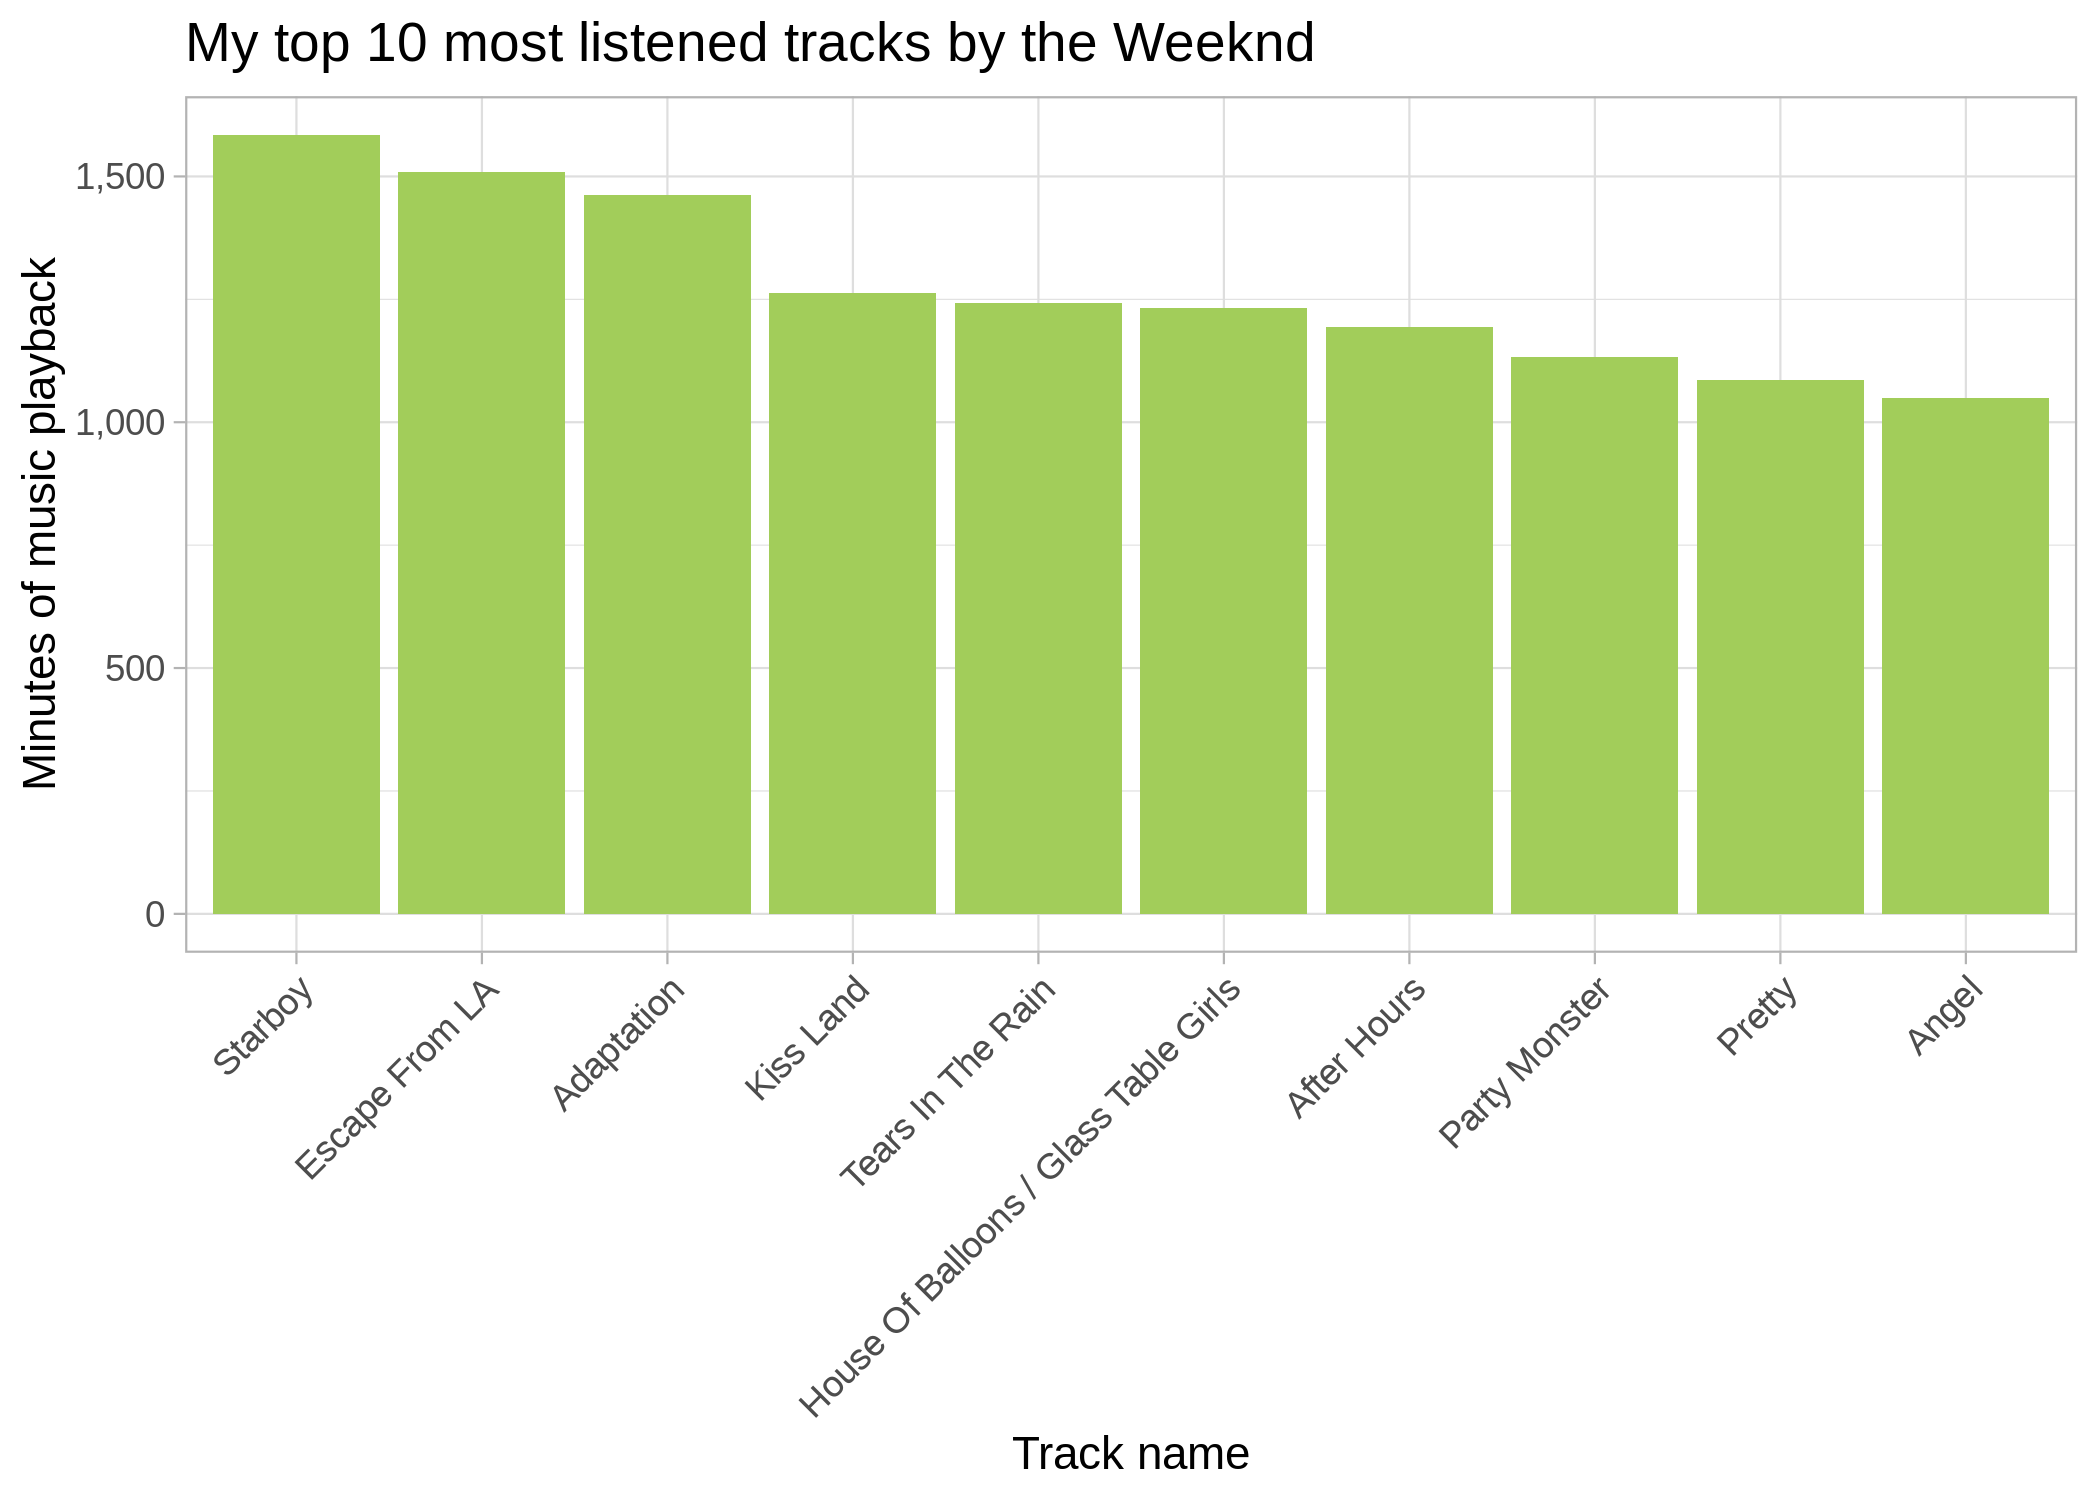

In [105]:
abel = spotify %>%
    filter(artistName == "The Weeknd") %>%
    group_by(trackName) %>%
    summarize(minutes = sum(minutes), .groups = 'drop') %>%
    arrange(minutes) %>%
    slice_max(minutes, n = 10) %>%
    mutate(trackName = fct_inorder(trackName))

p = ggplot(abel, aes(x=trackName, y= minutes))

p = p + geom_col(fill='darkolivegreen3')

p = p + theme_light()

p = p + theme(axis.text.x = element_text(angle = 45,  hjust= 1))

p = p + scale_y_continuous(labels = comma)

p = p + labs(x= "Track name", y= "Minutes of music playback", 
             title = "My top 10 most listened tracks by the Weeknd")

p

### Now for the moment of truth... how much of my life did I spend listening to music this past year? 
I totaled the minutes from Nov 2020-21 as well as the minutes from Jan-Nov 2021. Since there are 525,600 minutes in a year, I divided the total minutes from both scenarios and found that I spent **42.4%** and **37.4%** of the past year and of 2021 so far, respectively, streaming Spotify music. If you're also curious, after dividing the amount of minutes I streamed the Weeknd by the total minutes from Nov 2020-21, I spent **25.1%** of the time streaming music listening to the Weeknd.

In [93]:
nov = spotify %>% summarize(totalMinutes=sum(minutes), percentage=totalMinutes/525600)
year2021 = spotify %>% filter(date >= "2021-01-01") %>% summarize(totalMinutes=sum(minutes), percentage=totalMinutes/525600)

nov 
year2021

totalMinutes,percentage
<dbl>,<dbl>
222825.8,0.4239456


totalMinutes,percentage
<dbl>,<dbl>
196323.5,0.3735226


### Spotify Wrapped 2021


Here's the actual Spotify Wrapped that was released at the beginning of December! For comparison, I found that my total minutes from Jan 1-Oct 31, 2021 was 196,323.5 minutes while Spotify reported it as 193,204. Interesting to consider where the extra 3,000 minutes came from...I've seen reddit threads about Spotify possibly not counting the minutes for Spotify Wrapped from all platforms (e.g. they might count streaming done on your phone and laptop but not on the tv). There were also some discrepancies in the top #5 artists, which could be explained by difference in minutes. <img src="spotify2021.JPG" alt="image" width="500"/> Regardless, it's pretty cool to see that I stream music on Spotify more than 99.5% of U.S. users. It's a good day to be a Spotify user!